In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import seaborn as sns

In [10]:
df = pd.read_csv('data/processed/train.csv')


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13708\1227308709.py:1: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/train.csv')


In [11]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [12]:
df = reduce_memory_usage(df)

Mem. usage decreased to 781.94 Mb (53.6% reduction)


In [13]:
df.isnull().sum()

date                                          0
customer_id                                   0
employee_index                            27734
country_of_residence                      27734
gender                                    27754
age                                           0
registration_date                         27734
new_customer                              27734
seniority                                     0
primary_customer                          27734
last_primary_date                       4600165
customer_type                             44139
relation_type                             44139
residence_index                           27734
foreigner_index                           27734
spouse_index                            4605663
channel                                   47028
deceased_index                            27734
address_type                              27734
province_code                             53772
province_name                           

In [14]:
def clean_dataset(df):
    """
    Clean and preprocess the banking dataset
    
    Parameters:
    df: pandas DataFrame - Raw dataset
    
    Returns:
    df: pandas DataFrame - Cleaned dataset
    """
    
    print("🧹 CLEANING DATASET...")
    print("="*40)
    
    # =============================
    # 1. HANDLE MISSING VALUES
    # =============================
    print("1️⃣ Handling missing values...")
    
    # Fill missing values for payroll indicators
    # These columns indicate if customer has payroll/pension products
    missing_before = df[['payroll_final_label', 'pensions_2_final_label']].isnull().sum()
    df.fillna(value={
        'payroll_final_label': 0,
        'pensions_2_final_label': 0
    }, inplace=True)
    
    print(f"   ✅ Filled payroll_final_label: {missing_before['payroll_final_label']} missing → 0")
    print(f"   ✅ Filled pensions_2_final_label: {missing_before['pensions_2_final_label']} missing → 0")
    
    # =============================
    # 2. CREATE CUSTOMER TENURE FEATURE
    # =============================
    print("\n2️⃣ Creating customer tenure feature...")
    
    # Convert date columns to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['registration_date'] = pd.to_datetime(df['registration_date'])
    
    # Calculate days since registration (customer tenure)
    days_column = (df['date'] - df['registration_date']).dt.days
    
    # Insert the new column at position 6
    df.insert(loc=6, column='customer_tenure_days', value=days_column)
    
    print(f"   ✅ Created 'customer_tenure_days' feature")
    print(f"   📊 Range: {days_column.min()} to {days_column.max()} days")
    
    # Drop the original registration_date column to save memory
    df.drop(columns=['registration_date'], inplace=True)
    print(f"   🗑️ Dropped 'registration_date' column")
    
    # =============================
    # 3. CONVERT LAST_PRIMARY_DATE TO BINARY INDICATOR
    # =============================
    print("\n3️⃣ Converting last_primary_date to binary indicator...")
    
    # Convert last_primary_date to binary: 1 if date exists, 0 if null
    # This indicates if customer was ever a primary customer
    original_nulls = df['last_primary_date'].isnull().sum()
    df['was_primary_customer'] = df['last_primary_date'].apply(
        lambda x: 1 if pd.notnull(x) else 0
    )
    
    print(f"   ✅ Created 'was_primary_customer' binary feature")
    print(f"   📊 {original_nulls:,} nulls → 0, {len(df) - original_nulls:,} dates → 1")
    
    # Drop the original last_primary_date column
    df.drop(columns=['last_primary_date'], inplace=True)
    print(f"   🗑️ Dropped 'last_primary_date' column")
    
    # =============================
    # 4. REMOVE CONSTANT/DUPLICATE COLUMNS
    # =============================
    print("\n4️⃣ Removing constant and duplicate columns...")
    
    # Remove address_type if it has the same value for all customers
    if 'address_type' in df.columns:
        unique_values = df['address_type'].nunique()
        if unique_values <= 1:
            df.drop(columns=['address_type'], inplace=True)
            print(f"   🗑️ Dropped 'address_type' (constant value)")
        else:
            print(f"   ✅ Kept 'address_type' ({unique_values} unique values)")
    
    # Remove province_code as it's duplicate of province_name
    if 'province_code' in df.columns and 'province_name' in df.columns:
        df.drop(columns=['province_code'], inplace=True)
        print(f"   🗑️ Dropped 'province_code' (duplicate of province_name)")
    
    # =============================
    # 5. CLEAN NUMERIC COLUMNS
    # =============================
    print("\n5️⃣ Cleaning numeric columns...")
    
    # Convert age column - handle 'NA' strings
    if 'age' in df.columns:
        age_before = df['age'].dtype
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
        age_nulls = df['age'].isnull().sum()
        print(f"   ✅ Cleaned 'age': {age_before} → numeric ({age_nulls:,} nulls)")
    
    # Convert seniority column - handle 'NA' strings and negative values
    if 'seniority' in df.columns:
        seniority_before = df['seniority'].dtype
        df['seniority'] = pd.to_numeric(df['seniority'], errors='coerce')
        
        # Handle special negative values (often -999999 means missing)
        negative_values = (df['seniority'] < 0).sum()
        if negative_values > 0:
            df['seniority'] = df['seniority'].where(df['seniority'] >= 0, np.nan)
            print(f"   ⚠️ Converted {negative_values:,} negative seniority values to NaN")
        
        seniority_nulls = df['seniority'].isnull().sum()
        print(f"   ✅ Cleaned 'seniority': {seniority_before} → numeric ({seniority_nulls:,} nulls)")
    
    # =============================
    # 6. SUMMARY STATISTICS
    # =============================
    print("\n📊 CLEANUP SUMMARY:")
    print("-" * 40)
    print(f"   Final shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Null values: {df.isnull().sum().sum():,}")
    
    # Show data types
    print(f"\n📋 DATA TYPES AFTER CLEANUP:")
    for dtype in df.dtypes.value_counts().index:
        count = df.dtypes.value_counts()[dtype]
        print(f"   {dtype}: {count} columns")
    
    return df


In [15]:
df_cleaned = clean_dataset(df.copy())

# Verify the changes
print(f"\n✅ DATASET CLEANING COMPLETED!")
print(f"Original columns: {df.shape[1]}")
print(f"Cleaned columns: {df_cleaned.shape[1]}")
print(f"Columns removed: {df.shape[1] - df_cleaned.shape[1]}")

# Show new columns created
new_columns = set(df_cleaned.columns) - set(df.columns)
if new_columns:
    print(f"New columns created: {list(new_columns)}")

# Update the main dataframe
df = df_cleaned

🧹 CLEANING DATASET...
1️⃣ Handling missing values...
   ✅ Filled payroll_final_label: 0 missing → 0
   ✅ Filled pensions_2_final_label: 0 missing → 0

2️⃣ Creating customer tenure feature...
   ✅ Created 'customer_tenure_days' feature
   📊 Range: -3.0 to 7498.0 days
   🗑️ Dropped 'registration_date' column

3️⃣ Converting last_primary_date to binary indicator...
   ✅ Created 'was_primary_customer' binary feature
   📊 4,600,165 nulls → 0, 6,146 dates → 1
   🗑️ Dropped 'last_primary_date' column

4️⃣ Removing constant and duplicate columns...
   🗑️ Dropped 'address_type' (constant value)
   🗑️ Dropped 'province_code' (duplicate of province_name)

5️⃣ Cleaning numeric columns...
   ✅ Cleaned 'age': object → numeric (27,734 nulls)
   ⚠️ Converted 14 negative seniority values to NaN
   ✅ Cleaned 'seniority': object → numeric (27,748 nulls)

📊 CLEANUP SUMMARY:
----------------------------------------
   Final shape: (4606311, 46)
   Memory usage: 2935.7 MB
   Null values: 5,979,487

📋 DATA T

In [16]:
df.isnull().sum()

date                                          0
customer_id                                   0
employee_index                            27734
country_of_residence                      27734
gender                                    27754
age                                       27734
customer_tenure_days                      27734
new_customer                              27734
seniority                                 27748
primary_customer                          27734
customer_type                             44139
relation_type                             44139
residence_index                           27734
foreigner_index                           27734
spouse_index                            4605663
channel                                   47028
deceased_index                            27734
province_name                             53772
activity_index                            27734
income                                   804566
segment                                 

# Univariate analysis

- Dataset train có cut-off date là 7/2015. 
- User có thể có nhiều record trong dataset với date (observation khác nhau )

In [21]:
target_cols = [
    "savings_account_final_label",
    "guarantees_final_label",
    "current_accounts_final_label",
    "deriv_investments_final_label",
    "payroll_accounts_final_label",
    "junior_accounts_final_label",
    "more_particular_accounts_final_label",
    "particular_accounts_final_label",
    "particular_plus_accounts_final_label",
    "short_term_deposits_final_label",
    "medium_term_deposits_final_label",
    "long_term_deposits_final_label",
    "e_account_final_label",
    "funds_final_label",
    "mortgage_final_label",
    "pensions_final_label",
    "loans_final_label",
    "taxes_final_label",
    "credit_card_final_label",
    "securities_final_label",
    "home_account_final_label",
    "payroll_final_label",
    "pensions_2_final_label",
    "direct_debit_final_label"
]

## Target

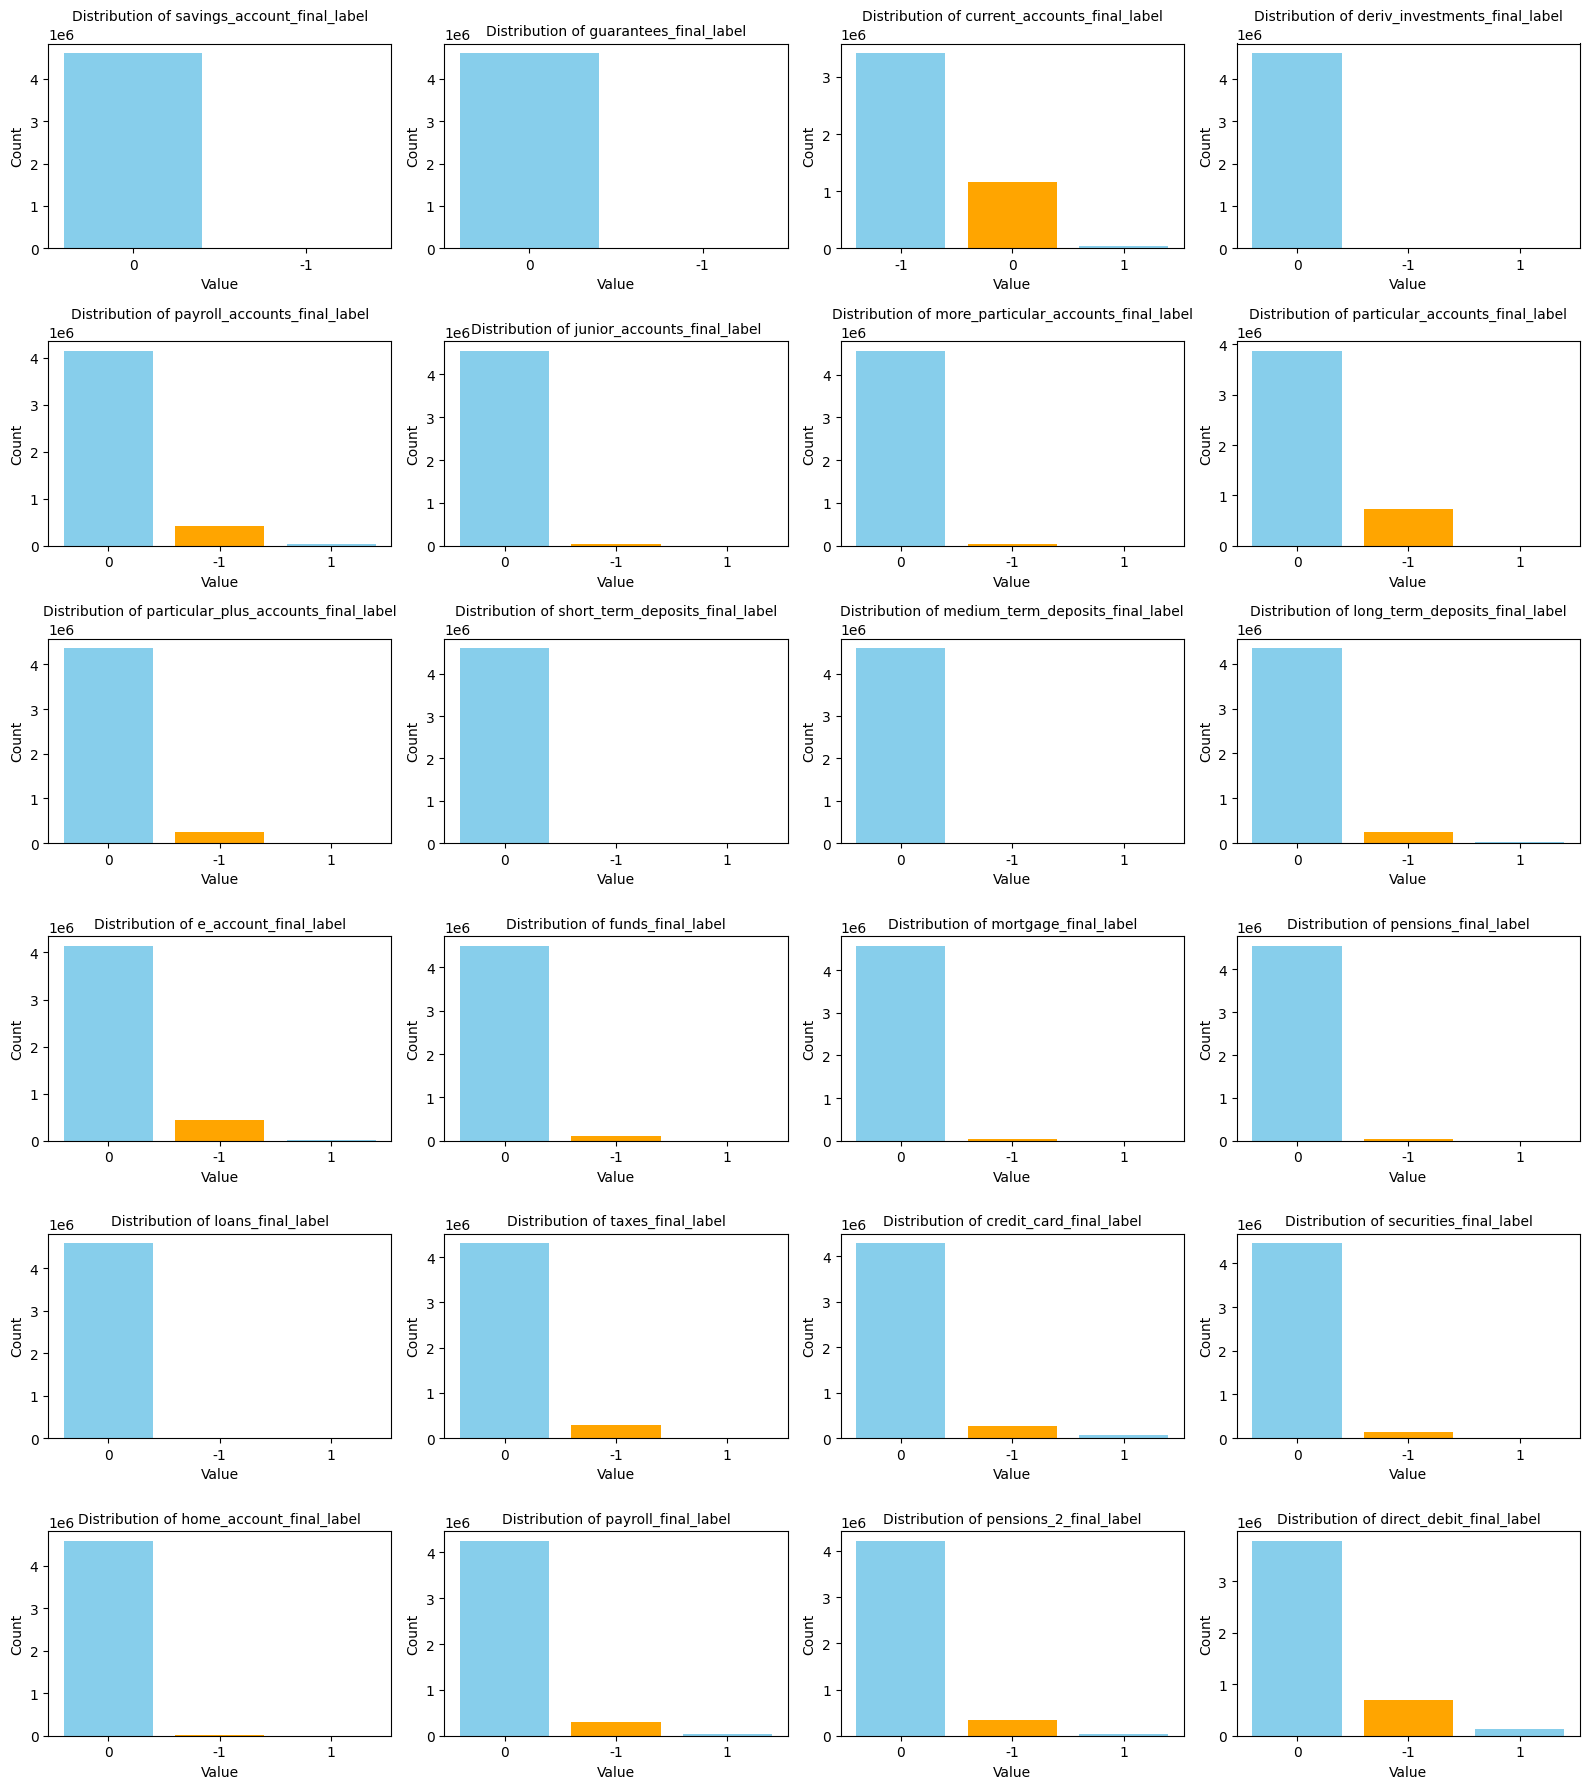

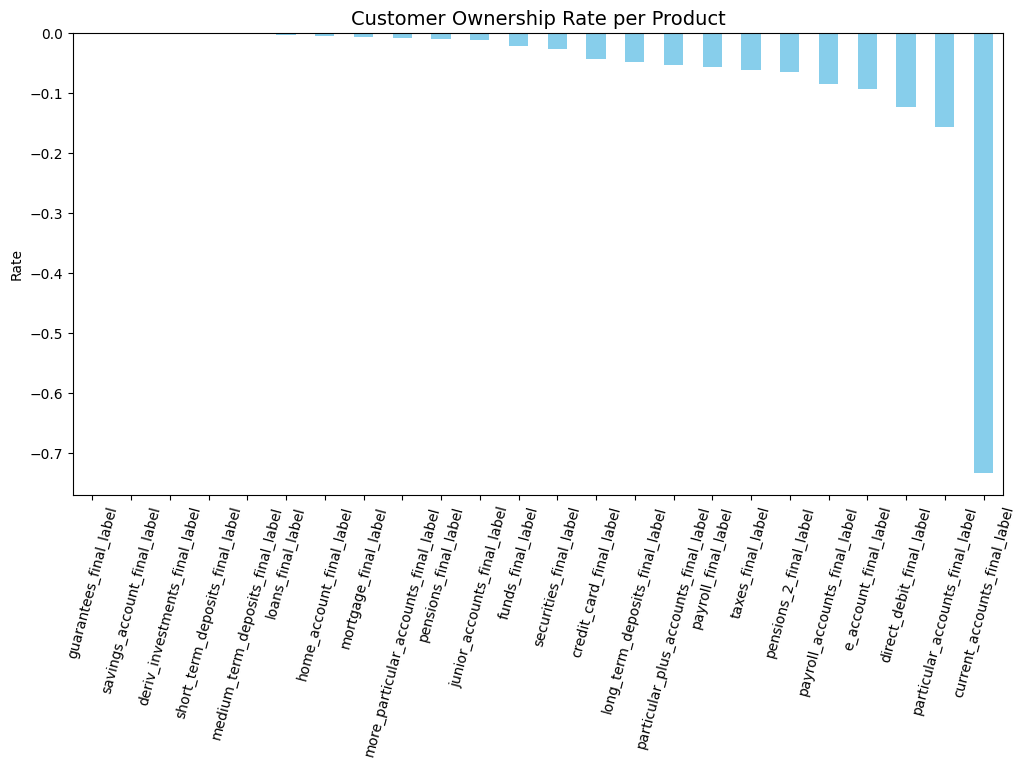

In [20]:

import math

n_cols = 4
n_rows = math.ceil(len(target_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    counts = df[col].value_counts(dropna=False)
    axes[i].bar(counts.index.astype(str), counts.values, color=["skyblue", "orange"])
    axes[i].set_title(f"Distribution of {col}", fontsize=10)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=0)

# Remove unused subplots if target count not divisible by n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot ownership rates for all products
target_rates = df[target_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
target_rates.plot(kind="bar", color="skyblue")
plt.title("Customer Ownership Rate per Product", fontsize=14)
plt.ylabel("Rate")
plt.xticks(rotation=75)
plt.show()


- Đa phần các khách hàng đã sỡ hữu các loại tài khoản trước đó. Số lương khách hàng chuyển đổi sang label 1 thấp hơn nhiều so với 0 và -1 
- Đa số khách hàng đã sở hữu sẵn current account 

## EMP index

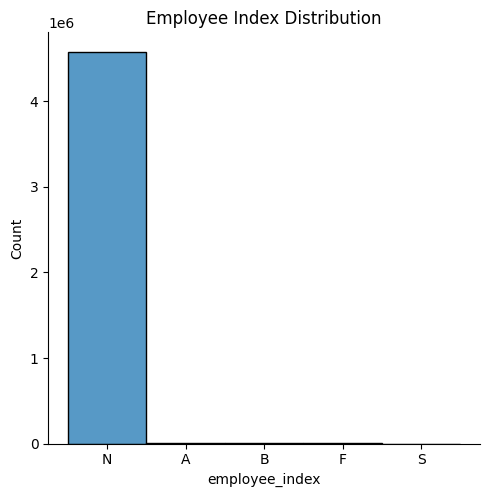

In [22]:
sns.displot(df['employee_index'])
plt.title('Employee Index Distribution')
plt.show()

Đa số khác hàng không phải là nhân viên của ngân hàng 

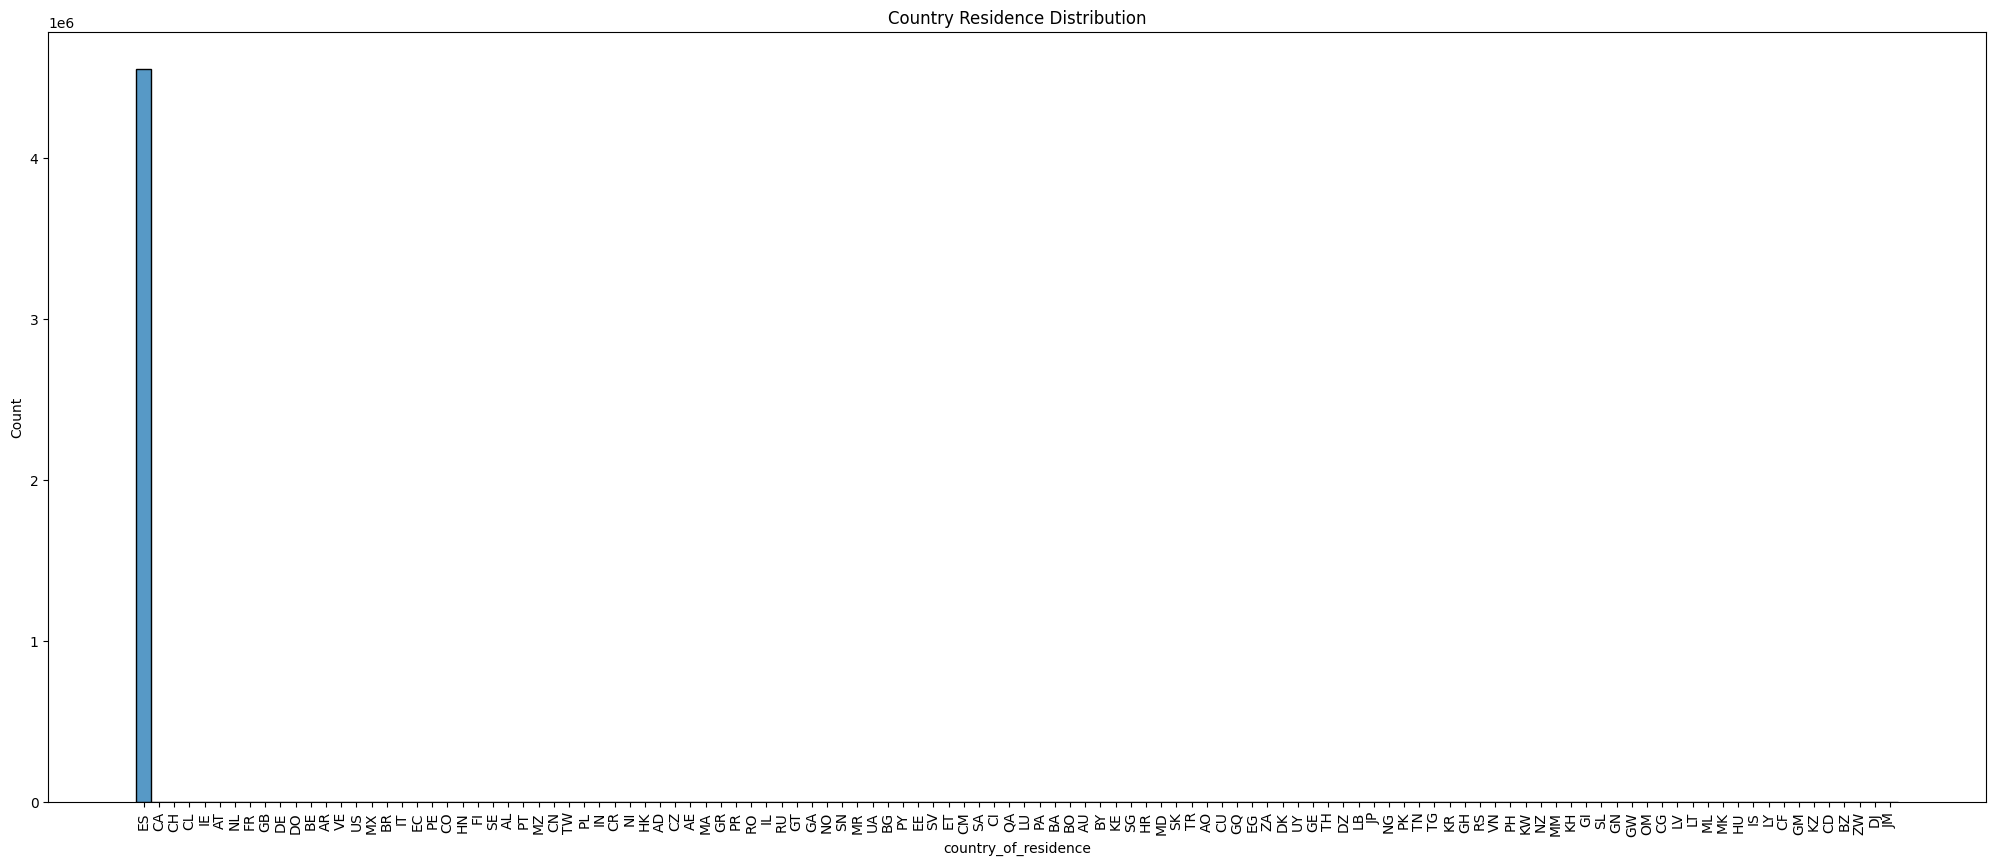

In [23]:
plt.figure(figsize=(25,10))
sns.histplot(df['country_of_residence'])
plt.title('Country Residence Distribution')
plt.xticks(rotation ='vertical')
plt.show()

Hầu hết các khách hàng thuộc nước ES

## Gender

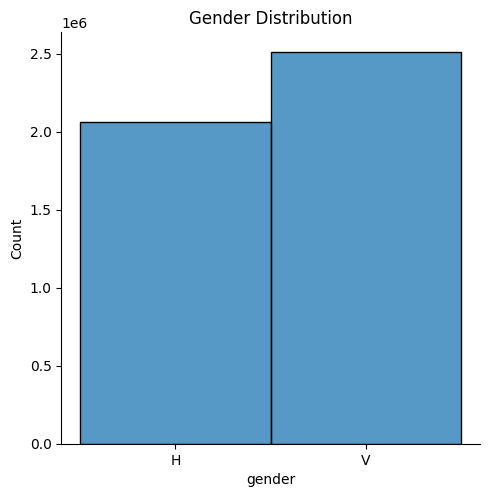

In [24]:
sns.displot(df['gender'])
plt.title('Gender Distribution')
plt.show()

Số khách hàng mang giới tính nữ nhiều hơn nam một chút. "V" là "Mujer", có nghĩa là nữ; còn "H" là "Hombre", có nghĩa là nam.

## Age

In [25]:
df['age'].unique()

array([ 35.,  23.,  22.,  24.,  65.,  28.,  25.,  26.,  53.,  27.,  32.,
        37.,  31.,  39.,  63.,  33.,  55.,  42.,  58.,  38.,  50.,  30.,
        45.,  44.,  36.,  29.,  60.,  57.,  67.,  47.,  nan,  34.,  48.,
        46.,  54.,  84.,  15.,  12.,   8.,   6.,  83.,  40.,  77.,  69.,
        52.,  59.,  43.,  10.,   9.,  49.,  41.,  51.,  78.,  16.,  11.,
        73.,  62.,  66.,  17.,  68.,  82.,  95.,  96.,  56.,  61.,  79.,
        72.,  14.,  19.,  13.,  86.,  64.,  20.,  89.,  71.,   7.,  70.,
        74.,  21.,  18.,  75.,   4.,  80.,  81.,   5.,  76.,  92.,  93.,
        85.,  91.,  87.,  90.,  94.,  99.,  98.,  88.,  97., 100., 101.,
       106., 103.,   3.,   2., 102., 104., 111., 107., 109., 105., 112.,
       115., 110., 116., 108., 113., 126., 117., 163.])

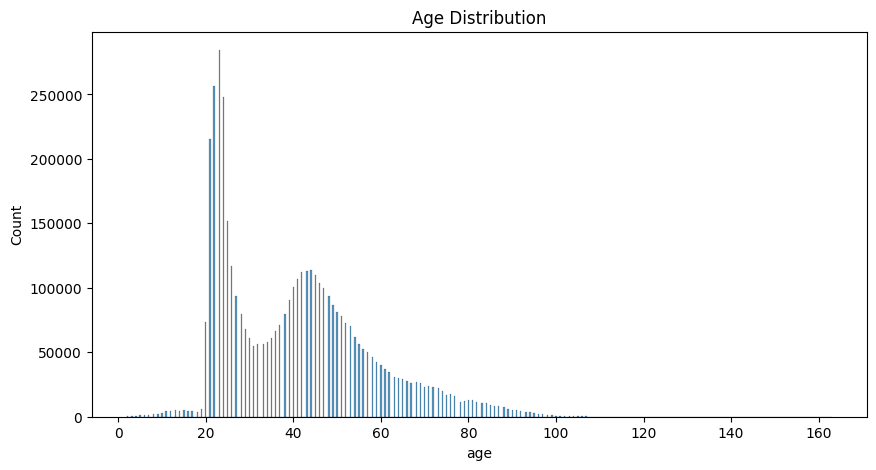

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'])
plt.title('Age Distribution')
plt.show()

*Insight*

- có rất ít khách hàng dưới 20 tuổi 
- Hầu hết khác hàng nằm trong độ tuổi từ 20-100, Tập trung nhiều nhất ở độ tuổi 20-25 

*Xử lí* : Group các nhóm khác hàng lại 20-30, 30-60 , 60+ 

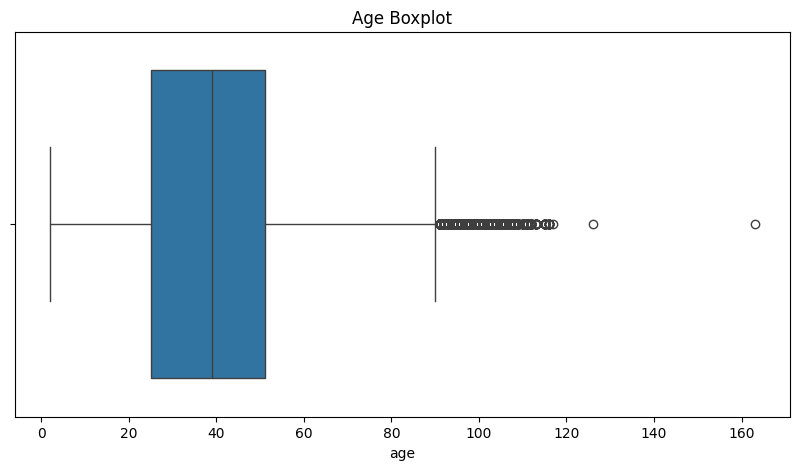

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['age'])
plt.title('Age Boxplot')
plt.show()

## Customer Seniority 

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13708\422799958.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seniority'])


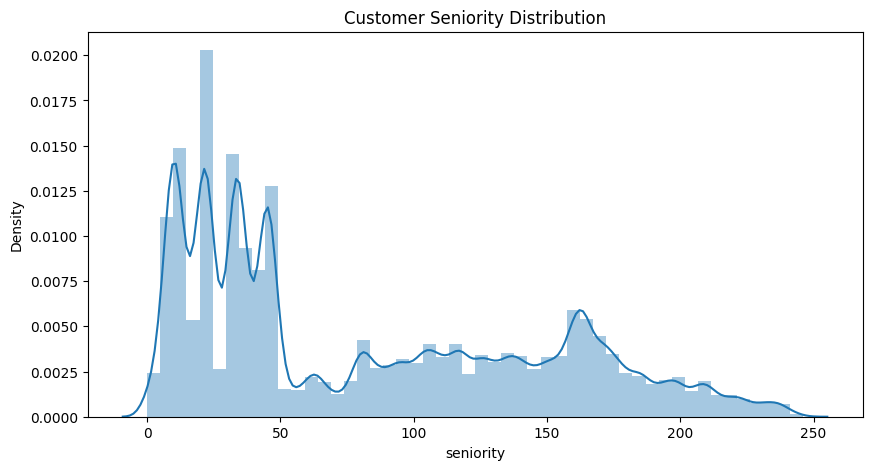

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(df['seniority'])
plt.title('Customer Seniority Distribution')
plt.ticklabel_format(useOffset=False,style = 'plain',axis = 'x')
plt.show()

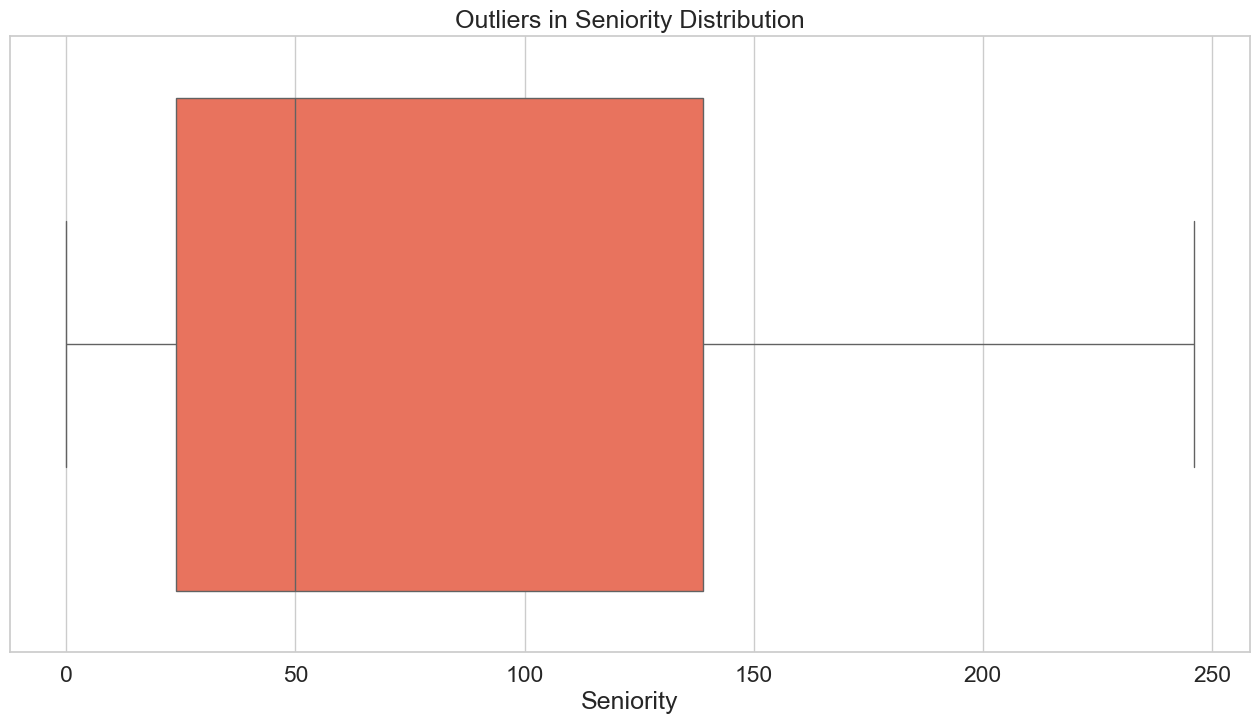

In [31]:
plt.figure(figsize=(16, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.set_style("whitegrid")
    sns.boxplot(x=df["seniority"].dropna(), color="tomato")
    plt.title("Outliers in Seniority Distribution")
    plt.xlabel("Seniority")
    plt.show()

## Customer Residence

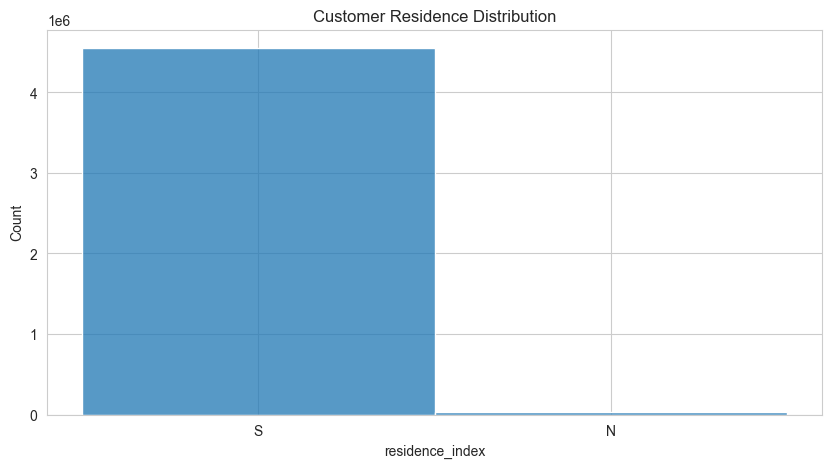

In [38]:
plt.figure(figsize=(10,5))
sns.histplot(df['residence_index'])
plt.title('Customer Residence Distribution')
plt.show()

Hầu hết các khách hàng có nơi cư trú là nước sở tại của ngân hàng

## Foreigner index 

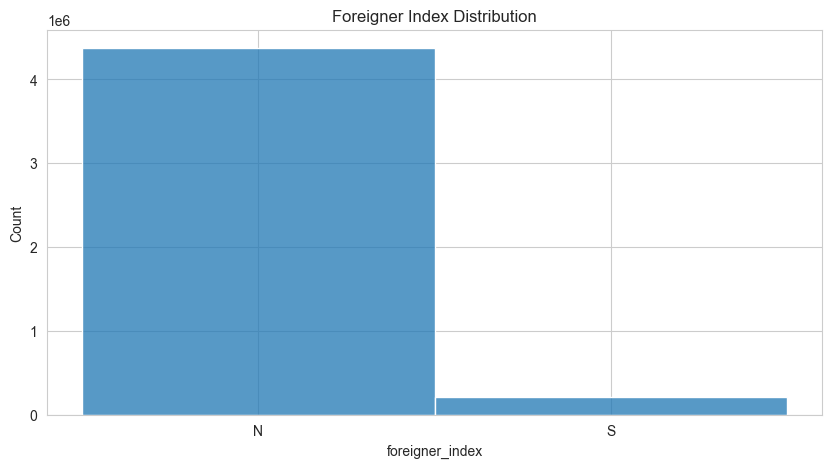

In [39]:
plt.figure(figsize=(10,5))
sns.histplot(df['foreigner_index'])
plt.title('Foreigner Index Distribution')
plt.show()

 Hầu hết các khách hàng có nơi sinh là nước sở tại của ngân hàng

## spouse_index

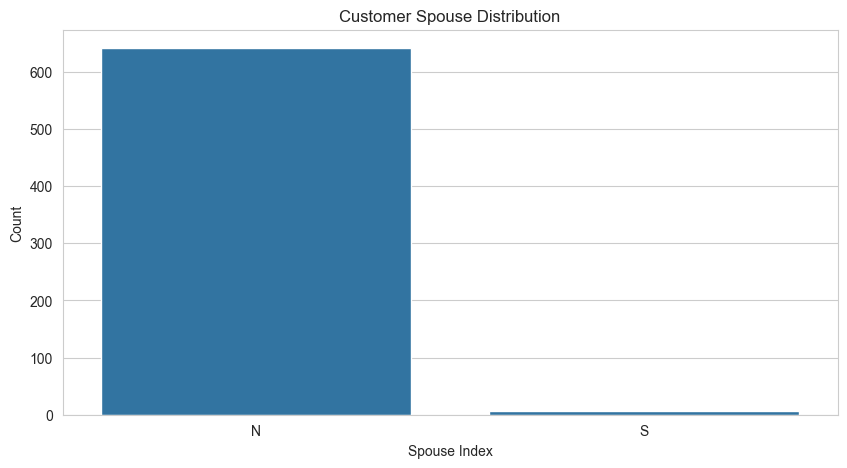

In [40]:
plt.figure(figsize=(10,5))
sns.countplot(x='spouse_index', data=df)
plt.title('Customer Spouse Distribution')
plt.xlabel('Spouse Index')
plt.ylabel('Count')
plt.show()

## Channel

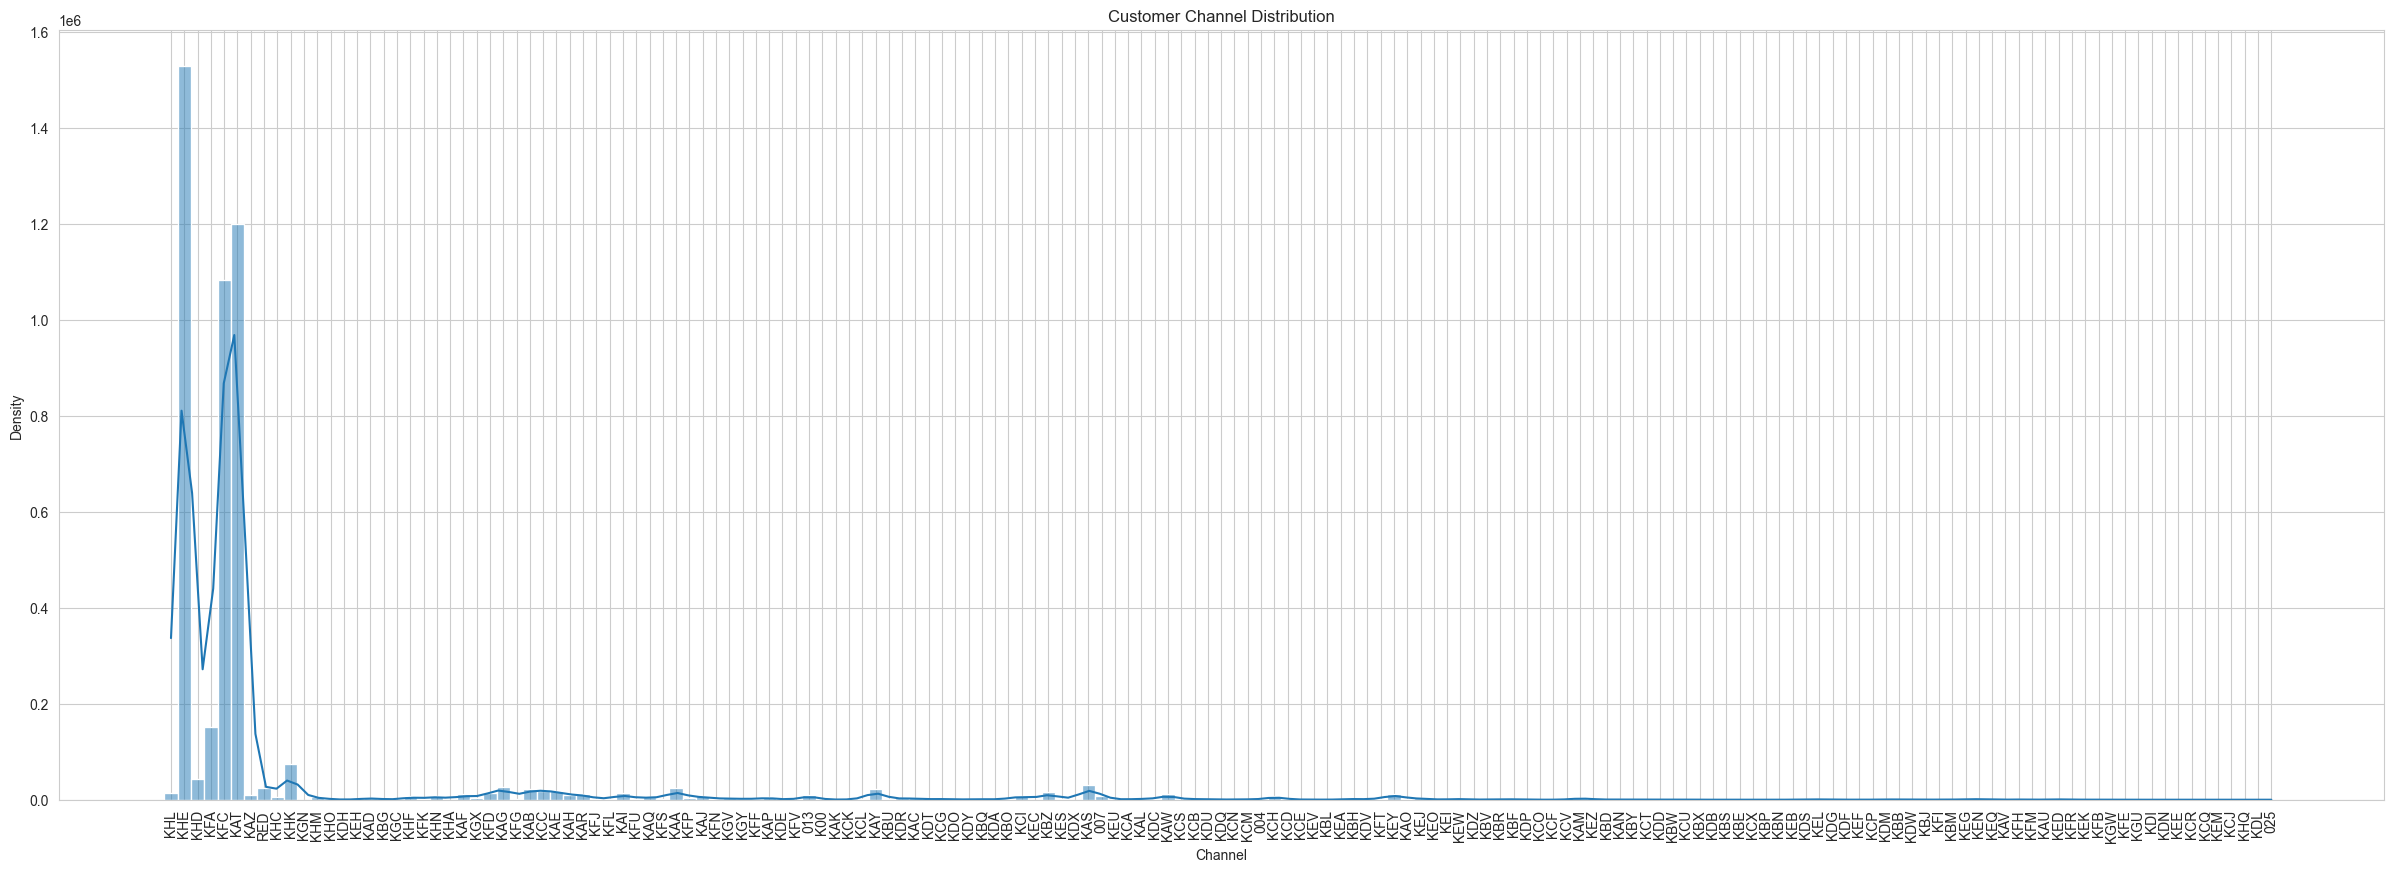

In [41]:
plt.figure(figsize=(30,10))
sns.histplot(df['channel'], bins=30, kde=True )
plt.title('Customer Channel Distribution')
plt.xlabel('Channel')
plt.ylabel('Density')
plt.xticks(rotation ='vertical')
plt.show()

KHE → quầy giao dịch trực tiếp tại chi nhánh chính hoặc chi nhánh lớn.

KAT → kênh qua đối tác hoặc chi nhánh phụ.

KFC → kênh qua cộng tác viên/đại lý môi giới.

KHO → kênh online hoặc hotline đăng ký

Đa số khách hàng tham gia bank qua các kênh 'KHE', 'KAT', 'KFC' và 'KHO'

## deceased_index 

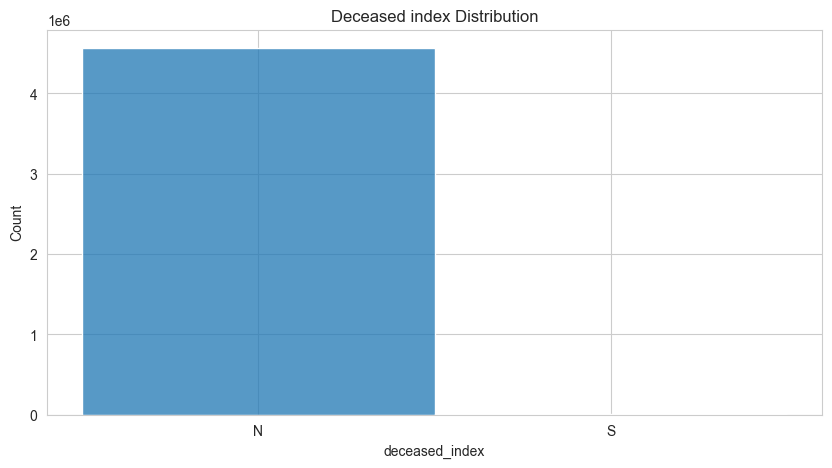

In [42]:
plt.figure(figsize=(10,5))
sns.histplot(df['deceased_index'])
plt.title('Deceased index Distribution')
plt.show()

Hầu hết các khách hàng chưa qua đời

## province_name

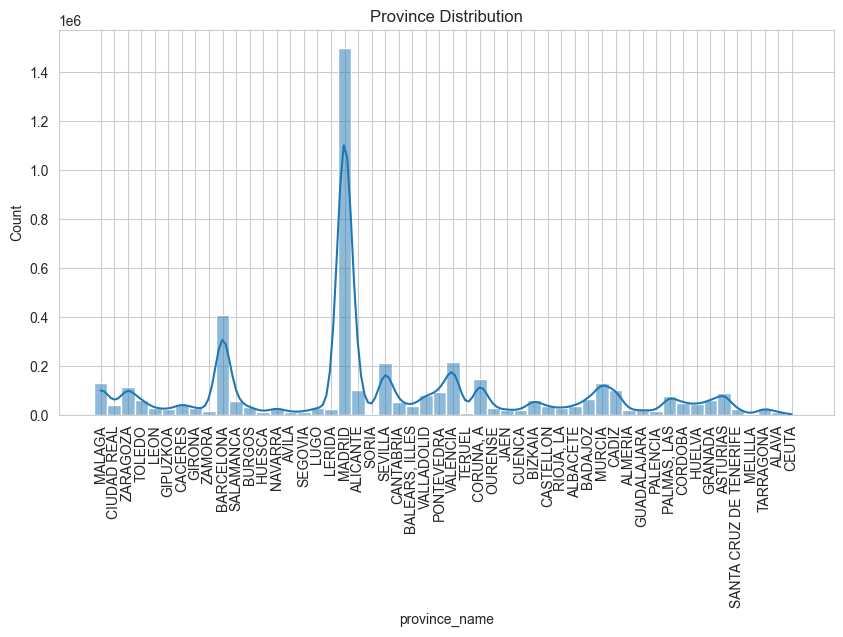

In [43]:
plt.figure(figsize=(10,5))
sns.histplot(df['province_name'], bins=30, kde=True)
plt.title('Province Distribution')
plt.xticks(rotation ='vertical')
plt.show()


Hầu hết khách hàng đến từ hai thành phố là 'MADRID' và 'BARCELONA'

## Segment

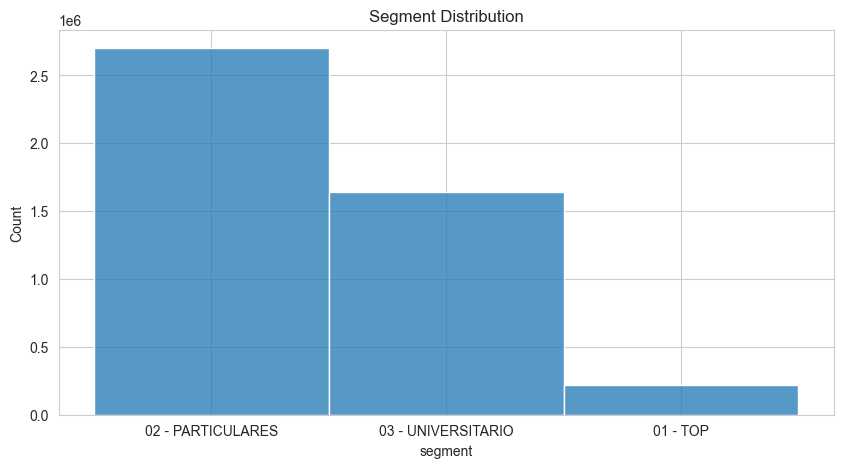

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(df['segment'])
plt.title('Segment Distribution')
plt.show()

Hầu hết khách hàng thuộc loại individuals và college graduated.

Có rất ít khách hàng VIPs

# Multivariate analysis

## age and target

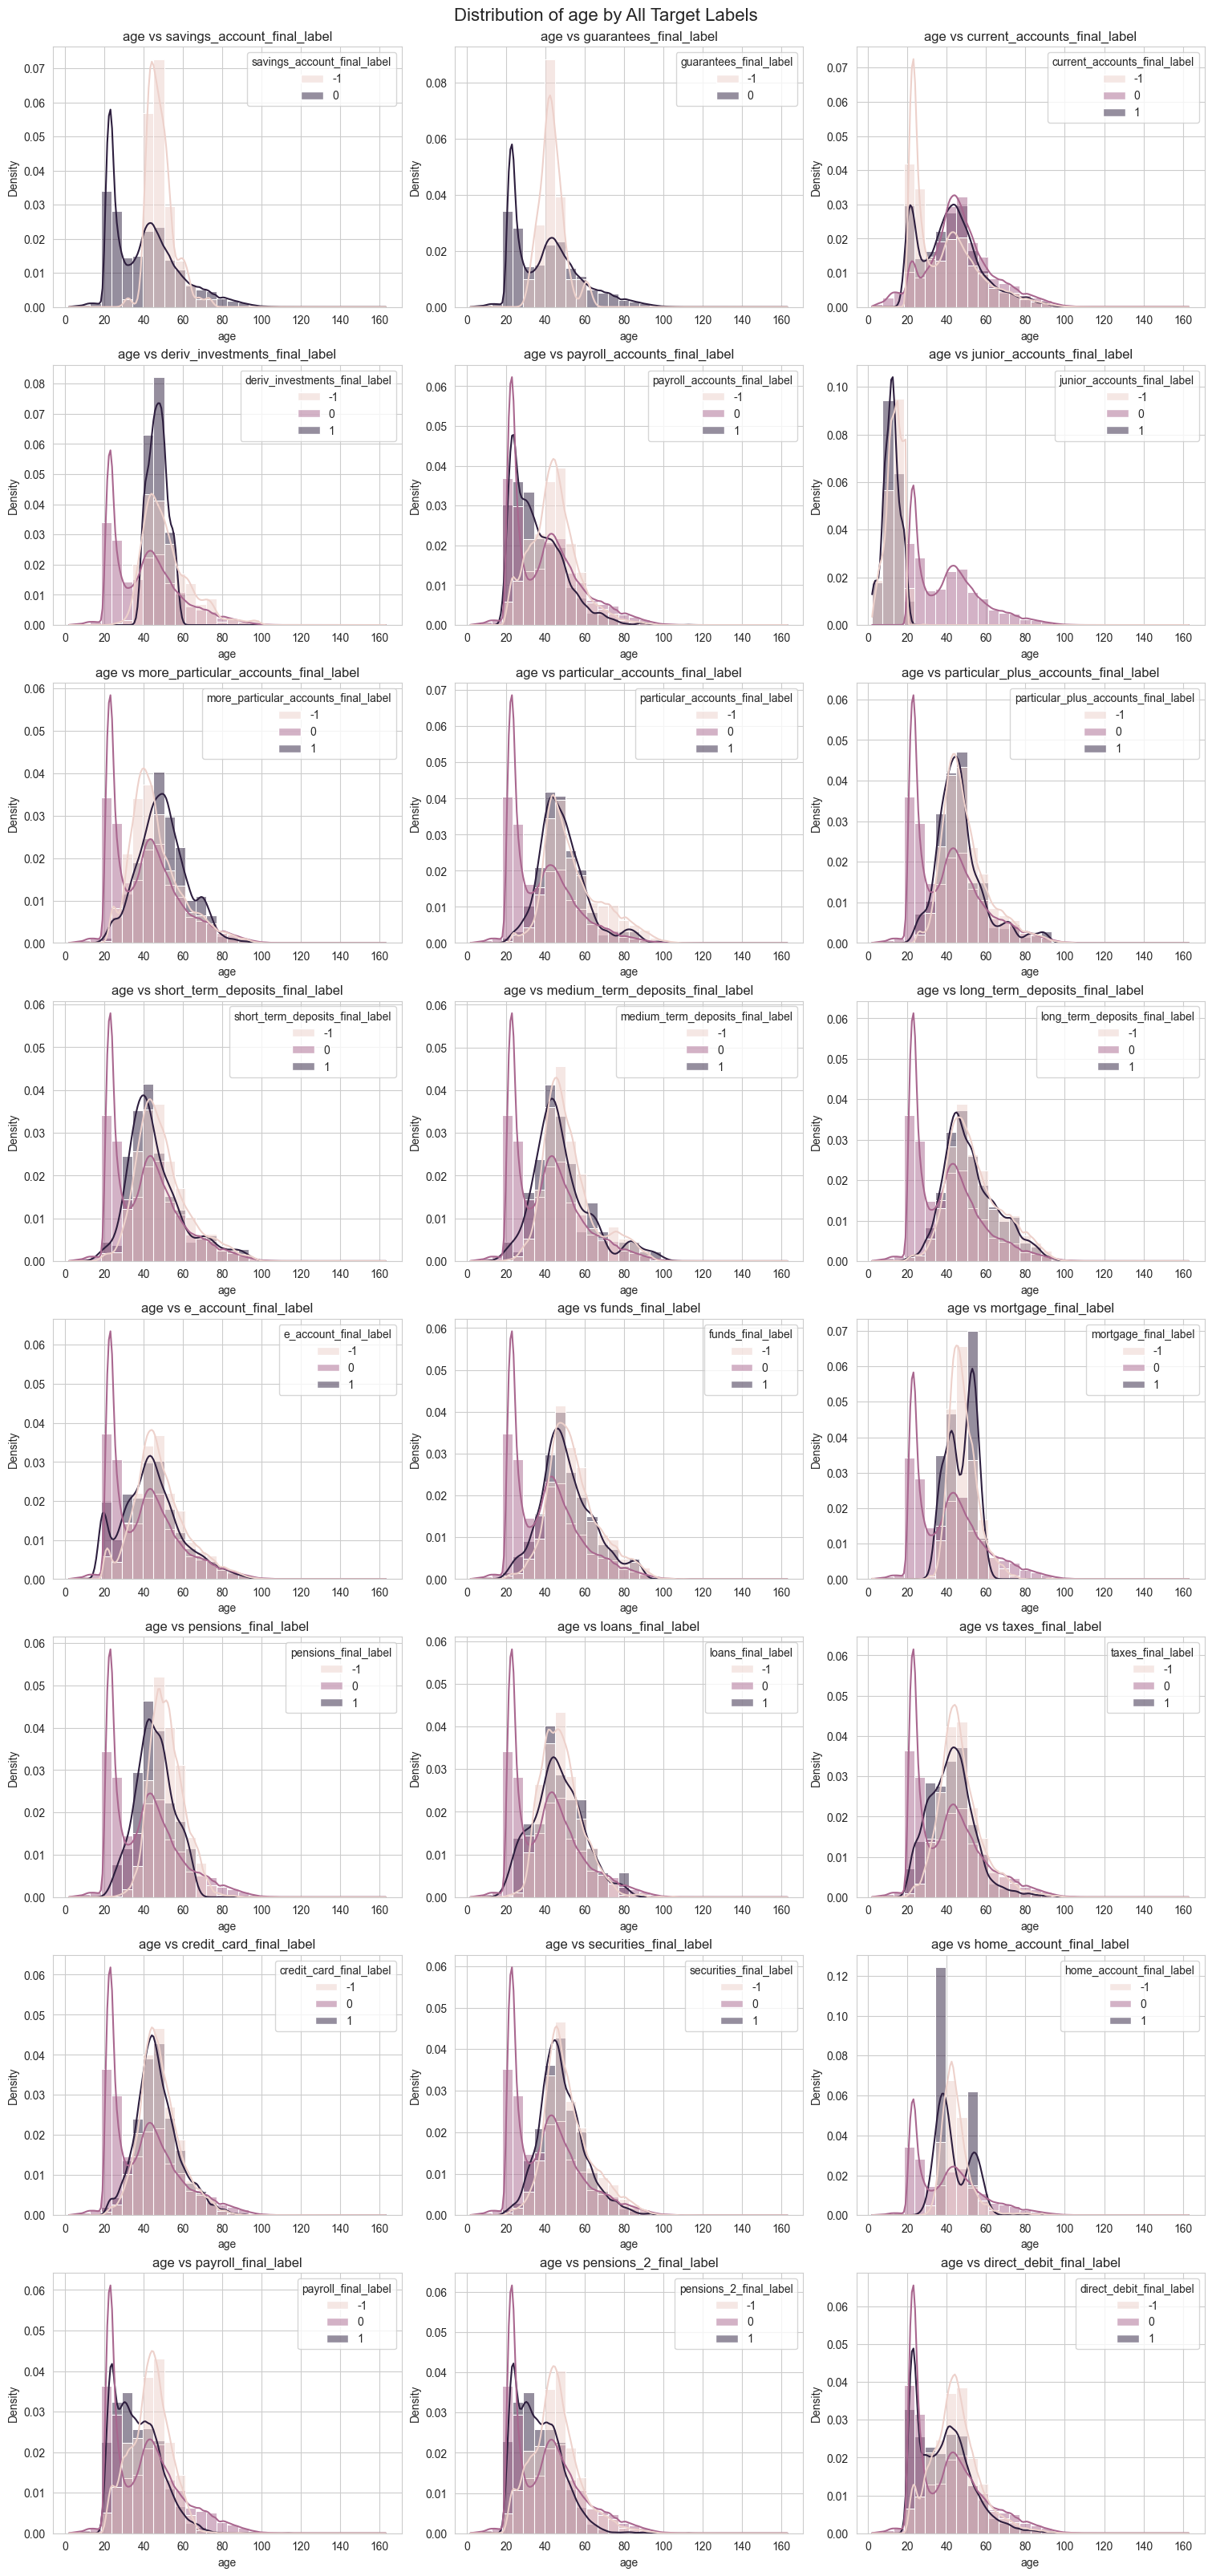

In [51]:

import math



feature = "age" 
n_cols = 3 
n_rows = math.ceil(len(target_cols) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)

axs = axs.flatten()
for i, col in enumerate(target_cols):
    sns.histplot(data=df, x=feature, bins=30, kde=True, hue=col,
                 stat="density", common_norm=False, ax=axs[i])
    axs[i].set_title(f"{feature} vs {col}")
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Density")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle(f"Distribution of {feature} by All Target Labels", fontsize=16)
plt.show()


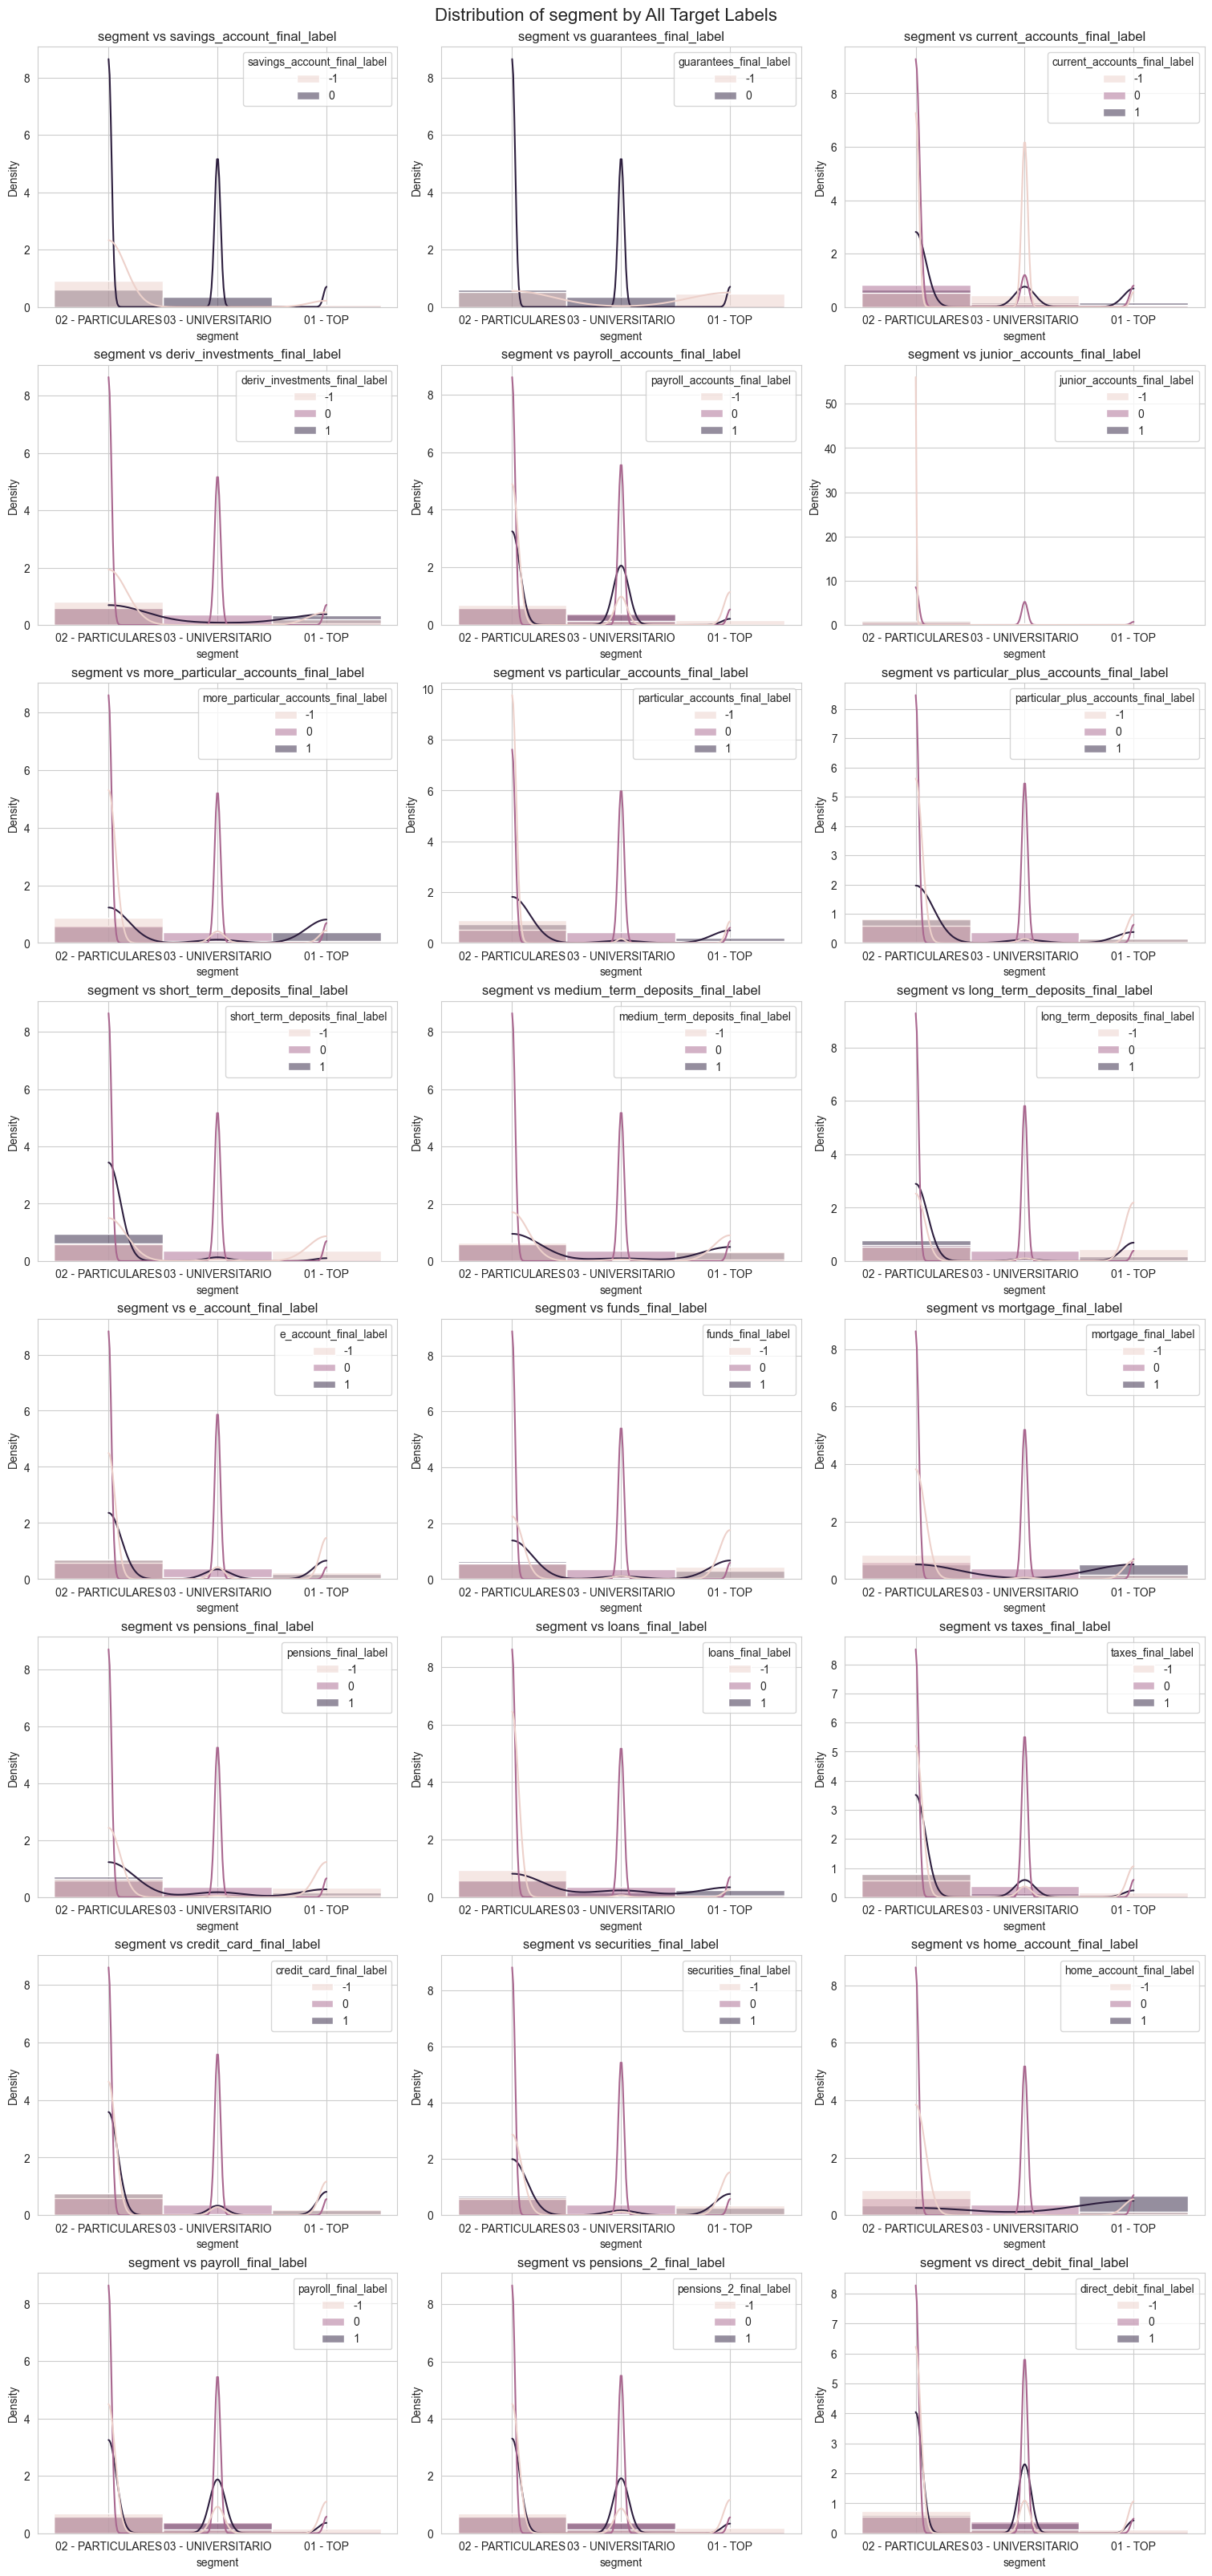

In [52]:


feature = "segment" 
n_cols = 3 
n_rows = math.ceil(len(target_cols) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)

axs = axs.flatten()
for i, col in enumerate(target_cols):
    sns.histplot(data=df, x=feature, bins=30, kde=True, hue=col,
                 stat="density", common_norm=False, ax=axs[i])
    axs[i].set_title(f"{feature} vs {col}")
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Density")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle(f"Distribution of {feature} by All Target Labels", fontsize=16)
plt.show()

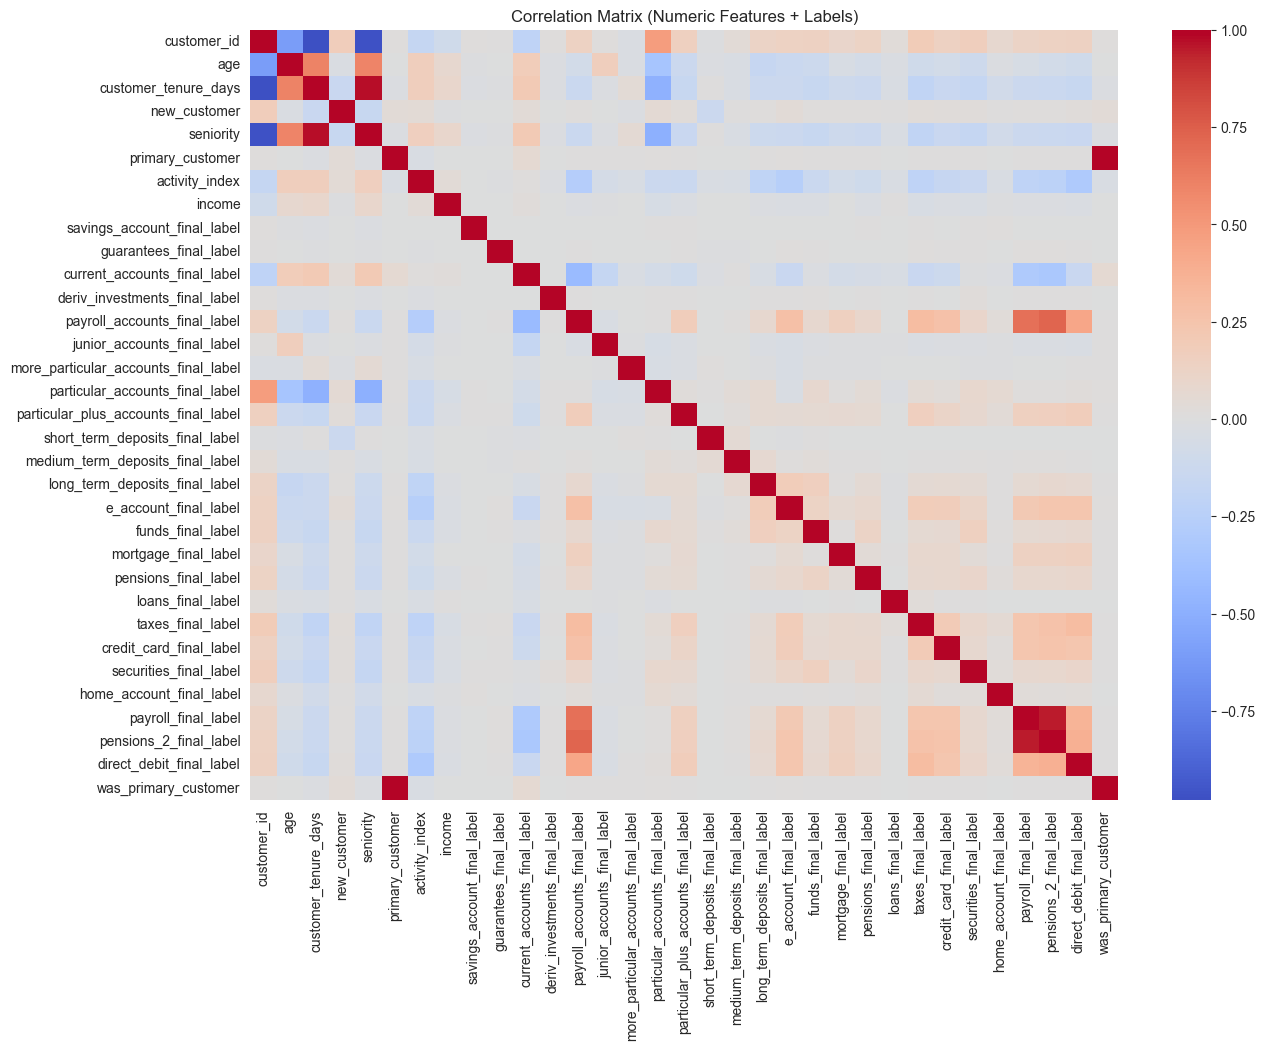

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# chọn cột numeric
num_cols = df.select_dtypes(include=["int8", "int16", "int32", "int64", 
                                     "float16", "float32", "float64"]).columns

# tính correlation
corr = df[num_cols].corr()

# vẽ heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features + Labels)")
plt.show()


c:\Users\LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


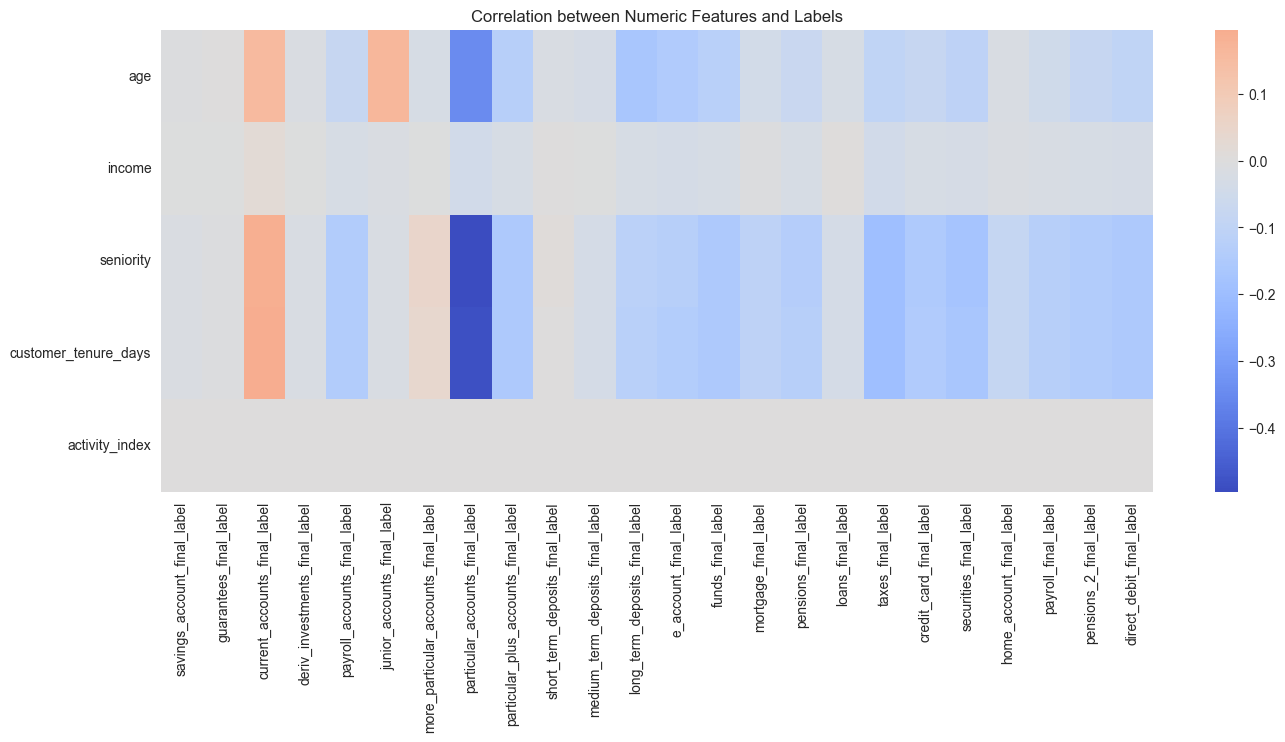

In [ ]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PowerTransformer

# =============================
# SCALE SKEWED NUMERIC FEATURES FOR PLOTTING
# =============================

def scale_for_plot(
    dataframe: pd.DataFrame,
    method: str = 'log1p',
    clip_quantiles: tuple | None = (0.01, 0.99),
    exclude_binary: bool = True,
    sample_n: int | None = 200_000,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Return a copy of dataframe with scaled numeric columns, suitable for plotting.
    - method: 'log1p' (default), 'robust', 'quantile', 'yeo-johnson'
    - clip_quantiles: winsorize extremes to reduce outlier impact
    - exclude_binary: drop ~{0,1} columns from scaling
    - sample_n: sample rows to speed up plotting (set None to keep all)
    """
    df = dataframe.copy()

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Exclude target columns if present
    if 'target_cols' in globals():
        numeric_cols = [c for c in numeric_cols if c not in target_cols]

    # Optionally exclude binary-like columns
    if exclude_binary:
        binary_like = [c for c in numeric_cols if df[c].dropna().isin([0, 1]).all()]
        numeric_cols = [c for c in numeric_cols if c not in binary_like]

    if len(numeric_cols) == 0:
        return df

    # Optionally clip extremes to reduce the influence of heavy tails
    if clip_quantiles is not None:
        q_low, q_high = clip_quantiles
        lower = df[numeric_cols].quantile(q_low)
        upper = df[numeric_cols].quantile(q_high)
        df[numeric_cols] = df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # Apply scaling
    if method == 'log1p':
        # Log1p for non-negative columns, robust for the rest
        nonneg_cols = [c for c in numeric_cols if (df[c] >= 0).all()]
        if nonneg_cols:
            df[nonneg_cols] = np.log1p(df[nonneg_cols])
        remaining_cols = [c for c in numeric_cols if c not in nonneg_cols]
        if remaining_cols:
            scaler = RobustScaler()
            df[remaining_cols] = scaler.fit_transform(df[remaining_cols])
    elif method == 'robust':
        scaler = RobustScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    elif method == 'quantile':
        qt = QuantileTransformer(output_distribution='normal', subsample=1_000_000, random_state=random_state)
        df[numeric_cols] = qt.fit_transform(df[numeric_cols])
    elif method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        df[numeric_cols] = pt.fit_transform(df[numeric_cols])
    else:
        raise ValueError("Unknown method. Use 'log1p', 'robust', 'quantile', or 'yeo-johnson'.")

    # Optional sampling to speed up plotting
    if sample_n is not None and len(df) > sample_n:
        df = df.sample(n=sample_n, random_state=random_state)

    return df

# Example usage for plotting:
# df_plot = scale_for_plot(df, method='log1p')
# sns.histplot(df_plot['income']); plt.show()
